# Re-weighting

OpenFisca-UK primarily relies on the Family Resources Survey, which has known issues with non-capture of households at the bottom and top of the income distribution. To correct for this, we apply a weight modification, optimised using gradient descent to minimise survey error against a diverse selection of targeting statistics. These include:

* Regional populations
* Household populations
* Population by tenure type
* Population by Council Tax band
* Country-level program statistics
* UK-wide program aggregates
* UK-wide program caseloads

The graph below shows the effect of the optimisation on each of these, compared to their starting values (under original FRS weights). All loss subfunctions improve from their starting values.

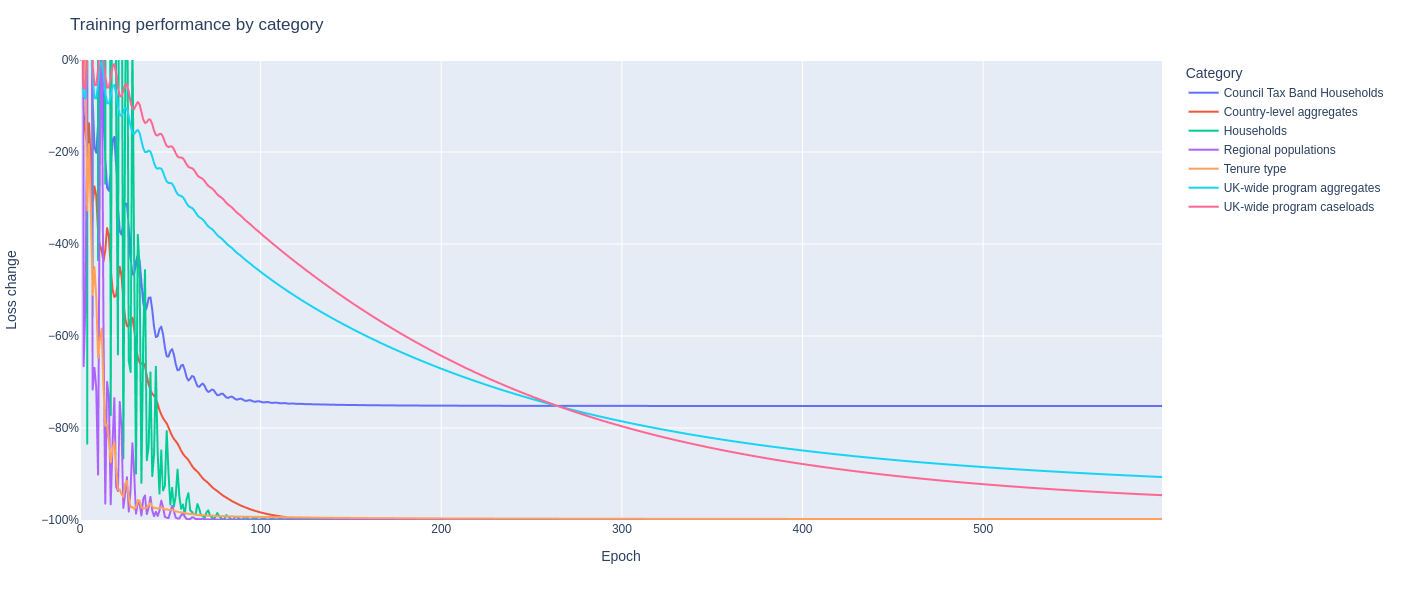

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import plotly.express as px

df = pd.read_csv(
    "https://github.com/PolicyEngine/openfisca-uk-reweighting/raw/master/no_val_split/training_log_run_1.csv.gz",
    compression="gzip",
)
ldf = (
    df.groupby(["category", "epoch"])
    .sum()
    .reset_index()
    .pivot(columns="category", values="loss", index="epoch")
)
ldf /= ldf.loc[0]
ldf -= 1
ldf = ldf.reset_index().melt(id_vars=["epoch"])
import plotly.express as px

ldf["hover"] = [
    f"At epoch {epoch}, the total loss from targets <br>in the category <b>{category}</b> <br>has <b>{'risen' if value > 0 else 'fallen'}</b> by <b>{abs(value):.1%}</b>."
    for epoch, category, value in zip(ldf.epoch, ldf.category, ldf.value)
]

px.line(
    ldf, x="epoch", y="value", color="category", custom_data=[ldf.hover]
).update_traces(hovertemplate="%{customdata[0]}").update_layout(
    title="Training performance by category",
    height=600,
    width=800,
    xaxis_title="Epoch",
    yaxis_title="Loss change",
    legend_title="Category",
    yaxis_range=(-1, 0),
    yaxis_tickformat=".0%",
)

## Changes to distributions

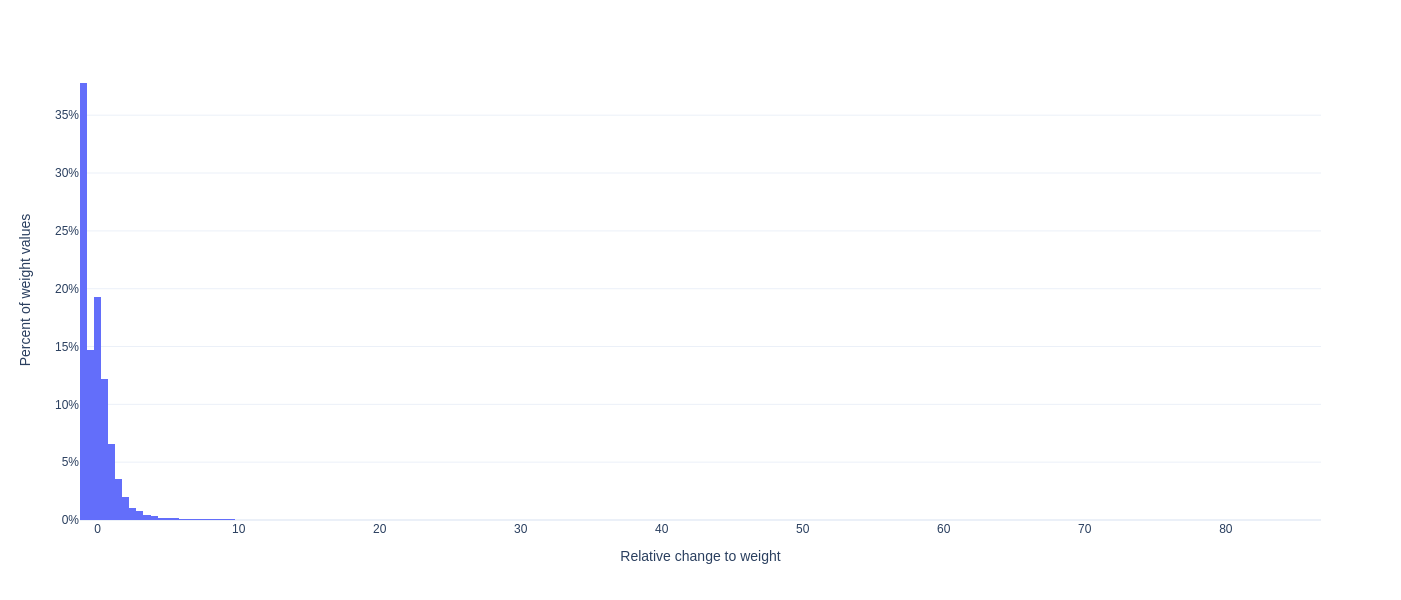

In [2]:
from openfisca_uk import Microsimulation

original = (
    Microsimulation(adjust_weights=False, duplicate_records=2)
    .calc("household_weight", 2022)
    .values
)
reweighted = Microsimulation().calc("household_weight", 2022).values

results = pd.DataFrame(
    dict(
        weight=reweighted / original - 1,
    )
)

weights = results.weight

px.histogram(
    x=results.weight, histnorm="probability", nbins=400
).update_layout(
    template="plotly_white",
    legend_title="Source",
    yaxis_tickformat=".0%",
    width=800,
    height=600,
    yaxis_title="Percent of weight values",
    xaxis_title="Relative change to weight",
)

In [3]:
from IPython.display import Markdown

Markdown(
    f"The above histogram shows the distribution of changes to weights. Around {(weights <= -1).mean():.0%} of the original (duplicated) dataset is dropped: this does not mean that every value provided by those households is untrustworthy - rather, it implies that the error introduced by this household contaminating the dataset with any incorrect information outweighs the benefits that the household can provide over the other households by adding an additional data point. The maximum relative increase to weights is a {weights.max():.0f}-factor increase, and {(weights > 0).mean():.0%} of the households see their weight increase."
)

The above histogram shows the distribution of changes to weights. Around 33% of the original (duplicated) dataset is dropped: this does not mean that every value provided by those households is untrustworthy - rather, it implies that the error introduced by this household contaminating the dataset with any incorrect information outweighs the benefits that the household can provide over the other households by adding an additional data point. The maximum relative increase to weights is a 87-factor increase, and 38% of the households see their weight increase.

### Validation

During initial training, we split the targets into training and validation groups (80%/20%), performing 5-fold cross-validation. The graph below shows the performance of validation metrics in each fold, as well as the average over the five folds.

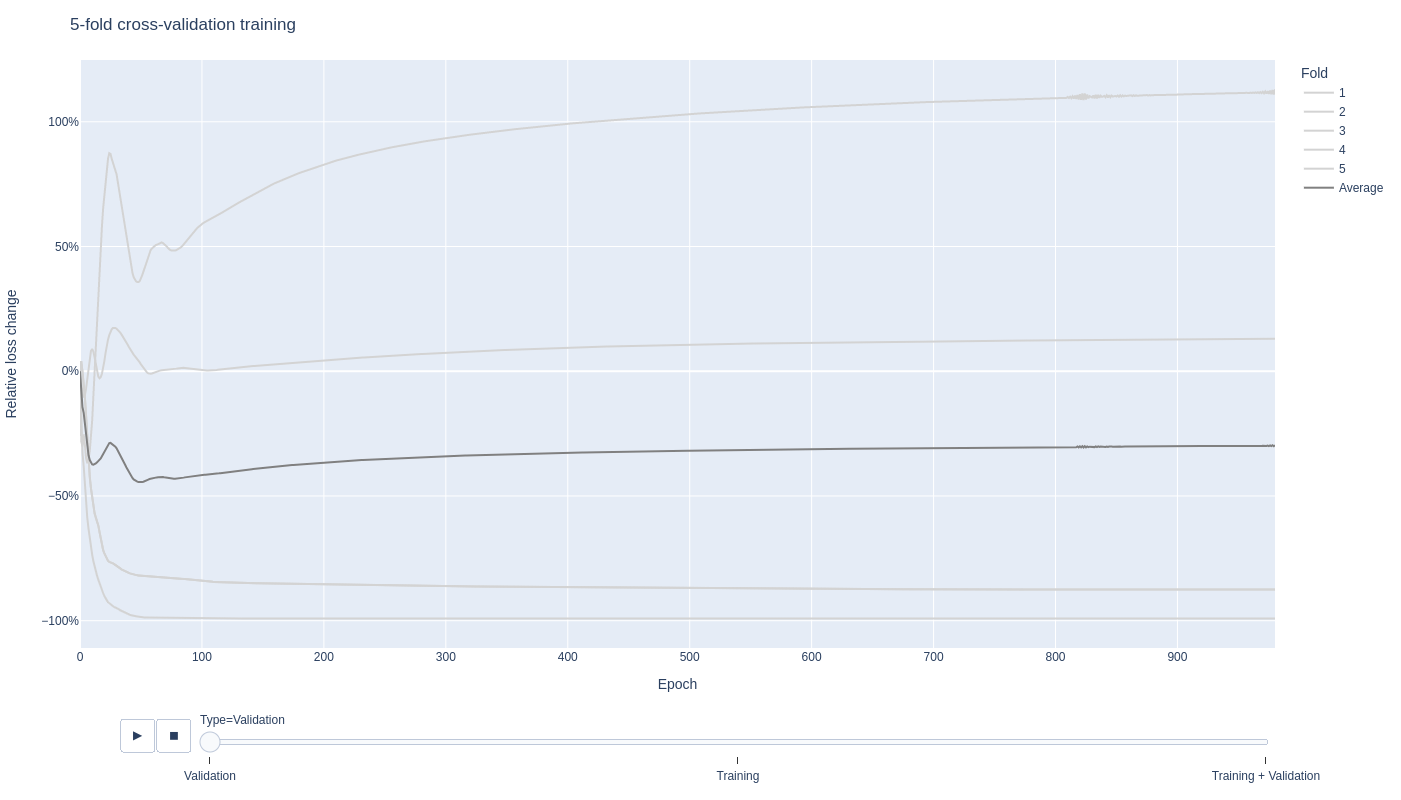

In [8]:
df = pd.read_csv(
    "https://github.com/PolicyEngine/openfisca-uk-reweighting/raw/master/train_val_split/training_log.csv.gz",
    compression="gzip",
)
xdf = pd.DataFrame()
for validation_type in (True, False, "Both"):
    if isinstance(validation_type, bool):
        condition = df.validation == validation_type
    else:
        condition = df.validation | ~df.validation
    x = (
        df[condition]
        .groupby(["run_id", "epoch"])
        .loss.sum()
        .reset_index()
        .pivot(columns="run_id", values="loss", index="epoch")
    )
    x /= x.loc[0]
    x -= 1
    x = x.dropna()
    x["Average"] = x.mean(axis=1)
    x["Type"] = {
        True: "Validation",
        False: "Training",
        "Both": "Training + Validation",
    }[validation_type]
    xdf = pd.concat([xdf, x])
px.line(
    xdf,
    y=xdf.columns,
    animation_frame="Type",
    color_discrete_sequence=["lightgrey"] * 5 + ["grey"],
).update_layout(
    title="5-fold cross-validation training",
    yaxis_title="Relative loss change",
    yaxis_tickformat=".0%",
    xaxis_title="Epoch",
    legend_title="Fold",
    width=800,
    height=800,
)

The below chart visualises the effect of the training process on each individual training and validation metric, by epoch.

In [ ]:
df["rel_error"] = df.pred / df.actual - 1
df["Type"] = np.where(df.validation, "Validation", "Training")
STEP_SIZE = 50

cdf = df[df.epoch % STEP_SIZE == 0]
cdf = cdf[
    (cdf.category == "Budgetary impact")
    | (cdf.category == "UK-wide program aggregates")
]

fig = px.scatter(
    cdf,
    animation_frame="epoch",
    x="actual",
    y="rel_error",
    color="Type",
    hover_data=df.columns,
    opacity=0.2,
)
layout = dict(
    title="Target metrics",
    width=800,
    height=800,
    legend_title="Type",
    yaxis_title="Relative error",
    yaxis_tickformat=".1%",
    xaxis_tickprefix="£",
    xaxis_title="Actual value",
    yaxis_range=(-1, 1),
)
fig.update_layout(**layout)

for i, frame in enumerate(fig.frames):
    frame.layout.update(layout)
    frame.layout[
        "title"
    ] = f"Budgetary impact target metric performance at {i * STEP_SIZE:,} epochs"

for step in fig.layout.sliders[0].steps:
    step["args"][1]["frame"]["redraw"] = True

for button in fig.layout.updatemenus[0].buttons:
    button["args"][1]["frame"]["redraw"] = True

import gif
import plotly.graph_objects as go

gif.save(
    [
        gif.frame(lambda: go.Figure(data=frame.data, layout=frame.layout))()
        for frame in fig.frames
    ],
    "scatterplot.gif",
    duration=3_000 / len(fig.frames),
)

fig